In [1]:
# imports
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import time
import xgboost as xgb
import seaborn as sns
import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

first_datetime = datetime.datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
last_datetime = datetime.datetime.strptime('2018-04-01 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-07-01 00:00:00'
train_valid_split_datetime = datetime.datetime.strptime('2018-03-01 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-06-01 00:00:00'
print('first_datetime:', first_datetime)
print('last_datetime:', last_datetime)
print('train_valid_split_datetime:', train_valid_split_datetime)

first_datetime: 2018-01-01 00:00:00
last_datetime: 2018-04-01 00:00:00
train_valid_split_datetime: 2018-03-01 00:00:00


In [2]:
taxi_zone_lookup = pd.read_csv('nyc-tlc/misc/taxi _zone_lookup.csv')
print('taxi_zone_lookup:', taxi_zone_lookup.shape)
print(taxi_zone_lookup.head())
manhattan_location_ids = taxi_zone_lookup[taxi_zone_lookup['Borough']=='Manhattan']['LocationID'].values
print('manhattan_location_ids:', manhattan_location_ids.shape)
print(manhattan_location_ids)

taxi_zone_lookup: (265, 4)
   LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone
manhattan_location_ids: (69,)
[  4  12  13  24  41  42  43  45  48  50  68  74  75  79  87  88  90 100
 103 104 105 107 113 114 116 120 125 127 128 137 140 141 142 143 144 148
 151 152 153 158 161 162 163 164 166 170 186 194 202 209 211 224 229 230
 231 232 233 234 236 237 238 239 243 244 246 249 261 262 263]


In [3]:
def get_5min_id(x):
    return (x-first_datetime).total_seconds()//(5*60)

def get_15min_id(x):
    return (x-first_datetime).total_seconds()//(15*60)

def get_30min_id(x):
    return (x-first_datetime).total_seconds()//(30*60)

In [4]:
train_valid_split_5min_id = get_5min_id(train_valid_split_datetime)
train_valid_split_15min_id = get_15min_id(train_valid_split_datetime)
train_valid_split_30min_id = get_30min_id(train_valid_split_datetime)
print('train_valid_split_5min_id:', train_valid_split_5min_id)
print('train_valid_split_15min_id:', train_valid_split_15min_id)
print('train_valid_split_30min_id:', train_valid_split_30min_id)

train_valid_split_5min_id: 16992.0
train_valid_split_15min_id: 5664.0
train_valid_split_30min_id: 2832.0


In [5]:
def filter_abnormal_data(sample):
    start = time.time()
    sample_manhattan = sample[sample['PULocationID'].isin(manhattan_location_ids)].copy()
    print('filter PULocationID:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['tpep_pickup_datetime'] = pd.to_datetime(sample_manhattan['tpep_pickup_datetime'])
    print('tpep_pickup_datetime:', time.time()-start)
    sample_manhattan['tpep_dropoff_datetime'] = pd.to_datetime(sample_manhattan['tpep_dropoff_datetime'])
    print('tpep_dropoff_datetime:', time.time()-start)
    sample_manhattan['trip_duration'] = (sample_manhattan['tpep_dropoff_datetime']-sample_manhattan['tpep_pickup_datetime']).dt.total_seconds()
    print('trip_duration:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] > 0]
    print('filter trip_duration:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] > 0]
    print('filter total_amount:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] >= first_datetime]
    print('filter tpep_pickup_datetime first_datetime:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] < last_datetime]
    print('filter tpep_pickup_datetime last_datetime:', sample_manhattan.shape, time.time()-start)
    return sample_manhattan

In [6]:
demo = False
if demo:
    sample = pd.read_csv('nyc-tlc/trip data/sample.csv')
    sample_manhattan = filter_abnormal_data(sample)
else:
    for m in range(1, 4):  # (1, 7)
        start = time.time()
        sample_1 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-0' + str(m) + '.csv')
        print('read_csv 2018-0'+str(m)+':', time.time()-start)
        sample_1 = filter_abnormal_data(sample_1)
        print('filter_abnormal_data:', time.time()-start)
        if m == 1:
            sample_manhattan = sample_1
        else:
            sample_manhattan = pd.concat([sample_manhattan, sample_1], axis=0)
        print('concat:', time.time()-start)
print('sample_manhattan:', sample_manhattan.shape)

start = time.time()
m = np.mean(sample_manhattan['trip_duration'])
s = np.std(sample_manhattan['trip_duration'])
print('m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] <= m + 2*s]
sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] >= m - 2*s]
print('filter trip_duration:', sample_manhattan.shape, time.time()-start)

print('sample_manhattan.shape:', sample_manhattan.shape)

read_csv 2018-01: 21.850707292556763
filter PULocationID: (7965703, 17) 1.9944961071014404
tpep_pickup_datetime: 4.1056969165802
tpep_dropoff_datetime: 6.158417701721191
trip_duration: 7.2835962772369385
filter trip_duration: (7960029, 18) 8.445795774459839
filter total_amount: (7956521, 18) 9.05440878868103
filter tpep_pickup_datetime first_datetime: (7956287, 18) 9.669448614120483
filter tpep_pickup_datetime last_datetime: (7956281, 18) 10.287065505981445
filter_abnormal_data: 32.348987102508545
concat: 32.349350452423096
read_csv 2018-02: 20.78898334503174
filter PULocationID: (7767881, 17) 1.944756269454956
tpep_pickup_datetime: 4.053094863891602
tpep_dropoff_datetime: 6.091134548187256
trip_duration: 7.177518129348755
filter trip_duration: (7762366, 18) 8.314838171005249
filter total_amount: (7758664, 18) 8.913658380508423
filter tpep_pickup_datetime first_datetime: (7758580, 18) 9.5177481174469
filter tpep_pickup_datetime last_datetime: (7758573, 18) 10.121580839157104
filter_abn

In [7]:
start = time.time()
#sample_manhattan['tpep_pickup_date'] = sample_manhattan['tpep_pickup_datetime'].dt.date
#print('tpep_pickup_date:', time.time()-start)
#sample_manhattan['tpep_dropoff_date'] = sample_manhattan['tpep_dropoff_datetime'].dt.date
#print('tpep_dropoff_date:', time.time()-start)
sample_manhattan['tpep_pickup_year'] = sample_manhattan['tpep_pickup_datetime'].dt.year
print('tpep_pickup_year:', time.time()-start)
sample_manhattan['tpep_pickup_month'] = sample_manhattan['tpep_pickup_datetime'].dt.month
print('tpep_pickup_month:', time.time()-start)
sample_manhattan['tpep_pickup_day'] = sample_manhattan['tpep_pickup_datetime'].dt.day
print('tpep_pickup_day:', time.time()-start)
sample_manhattan['tpep_pickup_hour'] = sample_manhattan['tpep_pickup_datetime'].dt.hour
print('tpep_pickup_hour:', time.time()-start)
sample_manhattan['tpep_pickup_weekday'] = sample_manhattan['tpep_pickup_datetime'].dt.weekday
print('tpep_pickup_weekday:', time.time()-start)
sample_manhattan['is_weekend'] = sample_manhattan['tpep_pickup_weekday'].map(lambda x: x >= 5 and 1 or 0)
print('is_weekend:', time.time()-start)
sample_manhattan['is_morning_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 7 <= x <= 9 and 1 or 0)
print('is_morning_peak:', time.time()-start)
sample_manhattan['is_evening_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 17 <= x <= 19 and 1 or 0)
print('is_evening_peak:', time.time()-start)
sample_manhattan['trip_speed'] = sample_manhattan['trip_distance']/sample_manhattan['trip_duration']
print('trip_speed:', time.time()-start)
sample_manhattan['store_and_fwd_flag'] = sample_manhattan['store_and_fwd_flag'].map(lambda x: x == 'N' and 0 or 1)
print('store_and_fwd_flag:', time.time()-start)

#store_and_fwd_flag_dummy = pd.get_dummies(sample_manhattan['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
#print('store_and_fwd_flag_dummy:', time.time()-start)
#passenger_count_dummy = pd.get_dummies(sample_manhattan['passenger_count'], prefix='pc', prefix_sep='_')
#print('passenger_count_dummy:', time.time()-start)
#RatecodeID_dummy = pd.get_dummies(sample_manhattan['RatecodeID'], prefix='rc', prefix_sep='_')
#print('RatecodeID_dummy:', time.time()-start)
#payment_type_dummy = pd.get_dummies(sample_manhattan['payment_type'], prefix='pt', prefix_sep='_')
#print('payment_type_dummy:', time.time()-start)

#sample_manhattan = pd.concat([sample_manhattan, store_and_fwd_flag_dummy, passenger_count_dummy, RatecodeID_dummy, payment_type_dummy], axis=1)  # TODO memory error
#print('concat:', time.time()-start)

sample_manhattan['tpep_pickup_5min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(5*60)
print('tpep_pickup_5min_id:', time.time()-start)
sample_manhattan['tpep_pickup_15min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(15*60)
print('tpep_pickup_15min_id:', time.time()-start)
sample_manhattan['tpep_pickup_30min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(30*60)
print('tpep_pickup_30min_id:', time.time()-start)

sample_manhattan.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)  # , 'tpep_pickup_date', 'tpep_dropoff_date'

tpep_pickup_year: 1.0235190391540527
tpep_pickup_month: 2.0645527839660645
tpep_pickup_day: 3.1094374656677246
tpep_pickup_hour: 4.156598091125488
tpep_pickup_weekday: 5.396307706832886
is_weekend: 14.028542280197144
is_morning_peak: 23.245847702026367
is_evening_peak: 32.27729368209839
trip_speed: 32.48301672935486
store_and_fwd_flag: 42.126962661743164
tpep_pickup_5min_id: 46.418752908706665
tpep_pickup_15min_id: 47.73378539085388
tpep_pickup_30min_id: 49.05333065986633


In [8]:
sample_manhattan.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,tpep_pickup_year,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,trip_speed,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
0,1,1,0.500,1,1,41,24,2,4.500,0.500,0.500,0.000,0.000,0.300,5.800,198.000,2018,1,1,0,0,0,0,0,0.003,4.000,1.000,0.000
1,1,1,2.700,1,1,239,140,2,14.000,0.500,0.500,0.000,0.000,0.300,15.300,1090.000,2018,1,1,0,0,0,0,0,0.002,8.000,2.000,1.000
2,1,2,0.800,1,1,262,141,1,6.000,0.500,0.500,1.000,0.000,0.300,8.300,355.000,2018,1,1,0,0,0,0,0,0.002,1.000,0.000,0.000
3,1,1,10.200,1,1,140,257,2,33.500,0.500,0.500,0.000,0.000,0.300,34.800,1949.000,2018,1,1,0,0,0,0,0,0.005,4.000,1.000,0.000
4,1,2,2.500,1,1,246,239,1,12.500,0.500,0.500,2.750,0.000,0.300,16.550,1068.000,2018,1,1,0,0,0,0,0,0.002,1.000,0.000,0.000


In [9]:
sample_manhattan.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,tpep_pickup_year,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,trip_speed,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
count,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000,24225902.000
mean,1.565,1.604,2.271,1.018,1.000,164.334,161.555,1.305,10.875,0.322,0.499,1.610,0.148,0.300,13.757,735.281,2018.000,2.025,15.628,13.776,3.003,0.272,0.134,0.187,0.003,13227.306,4408.769,2204.134
std,0.496,1.253,2.589,0.214,0.000,66.333,69.151,0.476,60.193,0.407,0.030,1.986,1.340,0.813,60.495,536.372,0.000,0.824,8.677,6.068,1.928,0.445,0.341,0.390,0.031,7331.039,2443.680,1221.840
min,1.000,0.000,0.000,1.000,1.000,4.000,1.000,1.000,0.000,-60.000,0.000,0.000,0.000,0.000,0.300,1.000,2018.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,0.900,1.000,1.000,113.000,113.000,1.000,6.000,0.000,0.500,0.000,0.000,0.300,8.160,369.000,2018.000,1.000,8.000,9.000,1.000,0.000,0.000,0.000,0.002,7019.000,2339.000,1169.000
50%,2.000,1.000,1.500,1.000,1.000,162.000,162.000,1.000,8.500,0.000,0.500,1.360,0.000,0.300,11.150,603.000,2018.000,2.000,16.000,14.000,3.000,0.000,0.000,0.000,0.003,13178.000,4392.000,2196.000
75%,2.000,2.000,2.560,1.000,1.000,233.000,233.000,2.000,12.500,0.500,0.500,2.250,0.000,0.300,15.800,951.000,2018.000,3.000,23.000,19.000,5.000,1.000,0.000,0.000,0.004,19553.000,6517.000,3258.000
max,2.000,192.000,1061.200,99.000,1.000,263.000,265.000,4.000,214748.440,66.660,60.800,496.000,980.800,4000.300,214750.240,8160.000,2018.000,3.000,31.000,23.000,6.000,1.000,1.000,1.000,90.133,25919.000,8639.000,4319.000


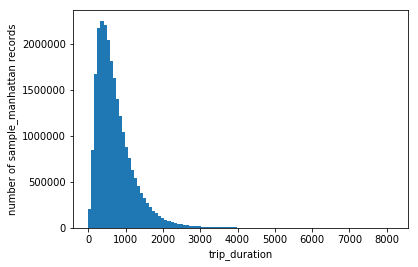

In [10]:
plt.hist(sample_manhattan['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of sample_manhattan records')
plt.show()

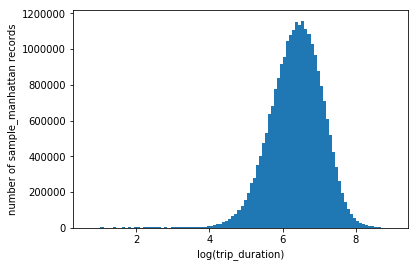

In [11]:
sample_manhattan['log_trip_duration'] = np.log(sample_manhattan['trip_duration'].values + 1)
plt.hist(sample_manhattan['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of sample_manhattan records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

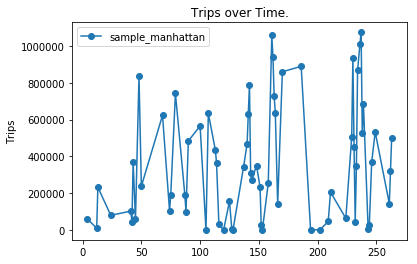

In [12]:
plt.plot(sample_manhattan.groupby(['PULocationID']).count()[['VendorID']], 'o-', label='sample_manhattan')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

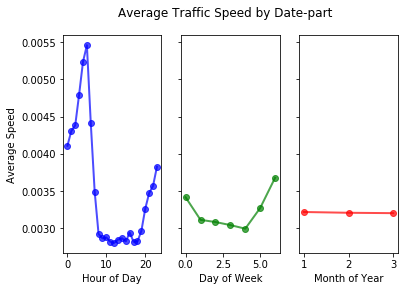

In [13]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(sample_manhattan.groupby('tpep_pickup_hour').mean()['trip_speed'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(sample_manhattan.groupby('tpep_pickup_weekday').mean()['trip_speed'], 'go-', lw=2, alpha=0.7)
ax[2].plot(sample_manhattan.groupby('tpep_pickup_month').mean()['trip_speed'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

In [14]:
taxi_zones_shape = gp.GeoDataFrame.from_file('nyc-tlc/misc/taxi_zones/taxi_zones.shp')
taxi_zones_shape = taxi_zones_shape[taxi_zones_shape['borough'] == 'Manhattan']
#taxi_zones_shape['color'] = 'green'
taxi_zones_shape.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ..."
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,..."
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,..."
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,..."


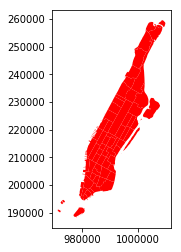

In [17]:
taxi_zones_shape.plot(color='red')

In [18]:
train_sample_5min_count = sample_manhattan[sample_manhattan['tpep_pickup_5min_id'] < train_valid_split_5min_id].groupby(['tpep_pickup_5min_id', 'PULocationID']).count()['VendorID']
print('train_sample_5min_count:', train_sample_5min_count.shape)
print(train_sample_5min_count.head())
valid_sample_5min_count = sample_manhattan[sample_manhattan['tpep_pickup_5min_id'] >= train_valid_split_5min_id].groupby(['tpep_pickup_5min_id', 'PULocationID']).count()['VendorID']
print('valid_sample_5min_count:', valid_sample_5min_count.shape)
print(valid_sample_5min_count.head())
print('valid_sample_5min_count:', type(valid_sample_5min_count))
#print(valid_sample_5min_count[5760][4])

train_sample_5min_count: (912549,)
tpep_pickup_5min_id  PULocationID
0.000                4               3
                     13              4
                     24              2
                     41              3
                     42              3
Name: VendorID, dtype: int64
valid_sample_5min_count: (485009,)
tpep_pickup_5min_id  PULocationID
16992.000            4               2
                     13              5
                     24              3
                     41              3
                     42              3
Name: VendorID, dtype: int64
valid_sample_5min_count: <class 'pandas.core.series.Series'>


In [19]:
sample_manhattan_5min_count = sample_manhattan.groupby(['tpep_pickup_5min_id', 'PULocationID']).count()['VendorID']

def generate_features(data_X):
    start = time.time()
    ago_5min = []
    ago_1day_now = []
    ago_7day_now = []
    ago_14day_now = []
    ago_21day_now = []
    ago_28day_now = []
    for index,row in data_X.iterrows():
        #print('index:', index)
        #print('row:', row)
        try:
            ago_5min.append(sample_manhattan_5min_count[index[0]-1][index[1]])
        except:
            ago_5min.append(0)
        try:
            ago_1day_now.append(sample_manhattan_5min_count[index[0]-288][index[1]])
        except:
            ago_1day_now.append(0)
        try:
            ago_7day_now.append(sample_manhattan_5min_count[index[0]-288*7][index[1]])
        except:
            ago_7day_now.append(0)
        try:
            ago_14day_now.append(sample_manhattan_5min_count[index[0]-288*14][index[1]])
        except:
            ago_14day_now.append(0)
        try:
            ago_21day_now.append(sample_manhattan_5min_count[index[0]-288*21][index[1]])
        except:
            ago_21day_now.append(0)
        try:
            ago_28day_now.append(sample_manhattan_5min_count[index[0]-288*28][index[1]])
        except:
            ago_28day_now.append(0)
    data_X['5min_ago'] = np.array(ago_5min)
    data_X['1day_ago_now'] = np.array(ago_1day_now)
    data_X['7day_ago_now'] = np.array(ago_7day_now)
    data_X['14day_ago_now'] = np.array(ago_14day_now)
    data_X['21day_ago_now'] = np.array(ago_21day_now)
    data_X['28day_ago_now'] = np.array(ago_28day_now)
    print('data_X time:', time.time()-start)
    return data_X

In [20]:
train_X = pd.DataFrame(train_sample_5min_count)
train_X = generate_features(train_X)
print('train_X:', train_X.shape)
print(train_X.head())
valid_X = pd.DataFrame(valid_sample_5min_count)
valid_X = generate_features(valid_X)
print('valid_X:', valid_X.shape)
print(valid_X.head())
train_Y = train_sample_5min_count.values
print('train_Y:', len(train_Y))
valid_Y = valid_sample_5min_count.values
print('valid_Y:', len(valid_Y))

data_X time: 1906.2665104866028
train_X: (912549, 7)
                                  VendorID  5min_ago  1day_ago_now  \
tpep_pickup_5min_id PULocationID                                     
0.000               4                    3         0             0   
                    13                   4         0             0   
                    24                   2         0             0   
                    41                   3         0             0   
                    42                   3         0             0   

                                  7day_ago_now  14day_ago_now  21day_ago_now  \
tpep_pickup_5min_id PULocationID                                               
0.000               4                        0              0              0   
                    13                       0              0              0   
                    24                       0              0              0   
                    41                       0          

In [21]:
def xgb_train_validate(train_X, train_Y, test_X, test_Y):
    xg_train = xgb.DMatrix(train_X.drop('VendorID', axis=1), label=train_Y)
    xg_test = xgb.DMatrix(test_X.drop('VendorID', axis=1), label=test_Y)
    # setup parameters for xgboost
    param = {}
    # scale weight of positive examples
    param['eta'] = 0.1  # default
    # param['eta'] = 0.02
    param['max_depth'] = 20  # default: 6
    param['silent'] = 1  # default
    param['nthread'] = 4  # default
    param['gamma'] = 1
    param['subsample'] = 0.9
    param['min_child_weight'] = 1
    param['colsample_bytree'] = 0.9
    param['lambda'] = 1
    param['booster'] = 'gbtree'
    param['eval_metric'] = 'mae'

    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    # num_round = 5
    num_round = 400

    # param['objective'] = 'reg:linear'
    param['objective'] = 'reg:gamma'
    bst = xgb.train(param, xg_train, num_round, watchlist)

    # xgb.plot_tree(bst)
    # plt.savefig('xgboost_tree.png')
    # xgb.plot_importance(bst)
    # plt.savefig('xgboost_importance.png')
    imp = bst.get_fscore()
    print(sorted(imp.items(), key=lambda d: d[1], reverse=True))

In [22]:
xgb_train_validate(train_X, train_Y, valid_X, valid_Y)

[0]	train-mae:16.6417	test-mae:17.0588
[1]	train-mae:16.5896	test-mae:17.0064
[2]	train-mae:16.5329	test-mae:16.9493
[3]	train-mae:16.4715	test-mae:16.8874
[4]	train-mae:16.4049	test-mae:16.8202
[5]	train-mae:16.3327	test-mae:16.7473
[6]	train-mae:16.2547	test-mae:16.6685
[7]	train-mae:16.1706	test-mae:16.5834
[8]	train-mae:16.0801	test-mae:16.4923
[9]	train-mae:15.9855	test-mae:16.3968
[10]	train-mae:15.8876	test-mae:16.2967
[11]	train-mae:15.7836	test-mae:16.1904
[12]	train-mae:15.6726	test-mae:16.0767
[13]	train-mae:15.5537	test-mae:15.9548
[14]	train-mae:15.4259	test-mae:15.8236
[15]	train-mae:15.2887	test-mae:15.6827
[16]	train-mae:15.1422	test-mae:15.5323
[17]	train-mae:14.9862	test-mae:15.3721
[18]	train-mae:14.8205	test-mae:15.2016
[19]	train-mae:14.6448	test-mae:15.0206
[20]	train-mae:14.4583	test-mae:14.8285
[21]	train-mae:14.2611	test-mae:14.6254
[22]	train-mae:14.053	test-mae:14.411
[23]	train-mae:13.8338	test-mae:14.1849
[24]	train-mae:13.6035	test-mae:13.9472
[25]	train-m

[204]	train-mae:3.44129	test-mae:3.59923
[205]	train-mae:3.44119	test-mae:3.59927
[206]	train-mae:3.44102	test-mae:3.59931
[207]	train-mae:3.44101	test-mae:3.59931
[208]	train-mae:3.44089	test-mae:3.59935
[209]	train-mae:3.44083	test-mae:3.59932
[210]	train-mae:3.4407	test-mae:3.59927
[211]	train-mae:3.44048	test-mae:3.59932
[212]	train-mae:3.44041	test-mae:3.59938
[213]	train-mae:3.44019	test-mae:3.59943
[214]	train-mae:3.44019	test-mae:3.59943
[215]	train-mae:3.43996	test-mae:3.59948
[216]	train-mae:3.4399	test-mae:3.59953
[217]	train-mae:3.43971	test-mae:3.59956
[218]	train-mae:3.43968	test-mae:3.59959
[219]	train-mae:3.4397	test-mae:3.59962
[220]	train-mae:3.43966	test-mae:3.5996
[221]	train-mae:3.43961	test-mae:3.59961
[222]	train-mae:3.43961	test-mae:3.5996
[223]	train-mae:3.43954	test-mae:3.59964
[224]	train-mae:3.43949	test-mae:3.59964
[225]	train-mae:3.43943	test-mae:3.5997
[226]	train-mae:3.43917	test-mae:3.59972
[227]	train-mae:3.43891	test-mae:3.59979
[228]	train-mae:3.4386

In [105]:
train_X_stat = train_X.apply(stat)
print('train_X_stat:')
print(train_X_stat)
valid_X_stat = valid_X.apply(stat)
print('valid_X_stat:')
print(valid_X_stat)

train_X_stat:
            VendorID      5min_ago  1day_ago_now   7day_ago_now  \
总数            307167        307167        307167         307167   
最小值                1             0             0              0   
最小值位置      (0.0, 45)      (0.0, 4)      (0.0, 4)       (0.0, 4)   
25%分位数         3.000         3.000         2.000          0.000   
中位数           10.000        10.000         9.000          3.000   
75%分位数        24.000        24.000        23.000         14.000   
均值            16.261        16.149        15.204          9.962   
最大值              151           151           151            130   
最大值位数   (3768.0, 79)  (3769.0, 79)  (4056.0, 79)  (2564.0, 230)   
平均绝对偏差        13.045        13.124        13.073         11.125   
方差           290.346       293.540       292.399        229.002   
标准差           17.040        17.133        17.100         15.133   
偏度             1.697         1.674         1.712          2.145   
峰度             3.367         3.287         3.400